# Pitch Outcome Cluster
- In order to train a general model for how a player will react to a given pitch, we need to consdier the strike zone
- what may be a ball for some players will be a strike for others.. so need to adjust for sz size
## Todo:
- find players who have similar strike zones
- train model on all players of this strike zone class
- write a function to get all players of this class
- train default model on players of this class to get how this average player performs
- train player specific model by starting with general model, and training on new player data

In [32]:
from src.data.data_utils import query_mlb_db, get_mlb_db_engine
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [48]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [72]:
def update_similar_sz_table():

    player_sz_data = query_mlb_db('''select batter, avg(sz_top) as sz_top, avg(sz_bot) as sz_bot
                                    from Statcast
                                    where sz_top & sz_bot is not null
                                    group by batter''')
    
    X = player_sz_data[['sz_top', 'sz_bot']].values
    
    # normalization or standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # clustering
    kmeans = KMeans(n_clusters=10)  
    kmeans.fit(X_scaled)
    cluster_labels = kmeans.labels_
    
    # add cluster labels 
    player_sz_data['cluster'] = cluster_labels

    engine = get_mlb_db_engine()

    try:
        if engine:
            upload_df = player_sz_data[['batter','cluster']]
            upload_df.to_sql('BatterStrikezoneCluster', engine, if_exists='replace', index=False)
        else:
            raise GetEngineError('Could not create db engine')
    except GetEngineError as e:
        print(e.args)

update_similar_sz_table()

      batter    sz_top    sz_bot  cluster
0     112526  3.437848  1.544430        6
1     134181  3.489695  1.592918        0
2     136860  3.545554  1.650189        8
3     150029  3.779508  1.744284        3
4     276520  3.565783  1.627952        0
...      ...       ...       ...      ...
3123  814307  3.360000  1.570000        6
3124  814431  3.210000  1.620000        7
3125  815694  3.210000  1.620000        7
3126  815842  3.355714  1.651429        2
3127  815888  3.425000  1.586667        6

[3128 rows x 4 columns]


In [53]:
player_sz_data[['sz_top', 'sz_bot']]

,sz_top,sz_bot
0,3.437848,1.544430
1,3.489695,1.592918
2,3.545554,1.650189
3,3.779508,1.744284
4,3.565783,1.627952
...,...,...
3123,3.360000,1.570000
3124,3.210000,1.620000
3125,3.210000,1.620000
3126,3.355714,1.651429


In [69]:
#vladdy: 665489
#soto: 665742
#schneider 676914

player_sz_data[['batter','cluster']].set_index('batter').loc[[665489, 665742, 676914]]

,cluster
batter,
665489,6
665742,1
676914,3


In [60]:
player_sz_data['cluster'].value_counts()

cluster
5    680
4    583
1    530
6    401
2    244
7    205
3    183
0    118
8    104
9     80
Name: count, dtype: int64

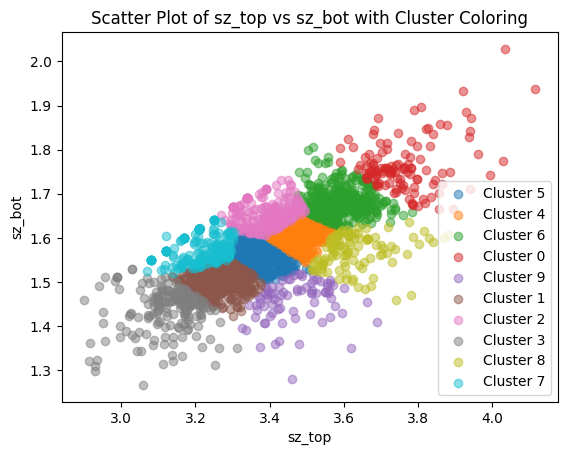

In [70]:
combinations = [('sz_top', 'sz_bot')]

# Plot scatter plots for each combination
for combination in combinations:
    var1, var2 = combination
    plt.figure()
    for cluster in player_sz_data['cluster'].unique():
        cluster_data = player_sz_data[player_sz_data['cluster'] == cluster]
        plt.scatter(cluster_data[var1], cluster_data[var2], label=f'Cluster {cluster}', alpha=0.5)
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.legend()
    plt.title(f'Scatter Plot of {var1} vs {var2} with Cluster Coloring')
    plt.show()